In [1]:
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.mps as mps
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
def get_default_device():
    cuda = torch.cuda.is_available()
    mps = torch.backends.mps.is_available()
    print(cuda, mps)

    if cuda:
        return torch.device("cuda")
    if mps:
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [3]:
device = get_default_device()
device

False True


device(type='mps')

In [4]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [5]:
# 1. 데이터 로드 및 전처리
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [6]:
data_dir = "/Users/mks/Documents/GitHub/AI/archive"
os.listdir(data_dir)

['fer20131.csv', '.DS_Store', 'train', 'ferSubmission.csv', 'val']

In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

# 경로를 자신의 데이터셋 위치로 변경

image_datasets = {
    x: ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes


In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x169eac2d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x169a16910>}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 4003, 'val': 1369}

In [10]:
# 2. ResNet18 모델 로드 및 수정
num_classes = len(class_names)

In [11]:
# Pretrained ResNet18 로드
resnet18 = models.resnet18(pretrained=True)

# 마지막 레이어 교체
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 3. ResNet9 가중치 불러오기
resnet9_weights_path = "/Users/mks/Documents/GitHub/AI/model/ResNet9_epoch-100_score-0.8633.pth"
resnet9_weights = torch.load(resnet9_weights_path, map_location=torch.device("cpu"))


/opt/anaconda3/envs/graduation/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/graduation/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/_w/6twp845j1tsgpylfv57d8d2r0000gn/T/ipykernel_61853/134002518.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

In [12]:
# 필요한 레이어의 가중치만 ResNet18에 초기화
# (layer1, layer2 등 공유 가능한 가중치만 가져옵니다)
resnet18_state_dict = resnet18.state_dict()
resnet18_state_dict.update({
    k: v for k, v in resnet9_weights.items() if k in resnet18_state_dict
})
resnet18.load_state_dict(resnet18_state_dict, strict=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
resnet18 = resnet18.to(device)

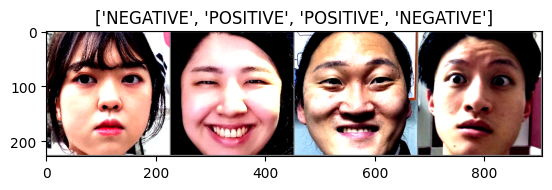

In [13]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## Training

In [14]:
# 4. 학습 준비
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
# 5. 학습 함수
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, save_path="best_model.pth"):
    """
    모델을 학습하고, validation accuracy가 향상될 때마다 모델을 저장합니다.

    Args:
        model: 학습할 모델 객체.
        dataloaders: train과 val 데이터셋을 포함하는 딕셔너리.
        criterion: 손실 함수.
        optimizer: 최적화 함수.
        scheduler: 학습률 스케줄러.
        num_epochs: 총 학습 epoch 수.
        save_path: 모델을 저장할 경로.

    Returns:
        학습된 모델 객체.
    """
    best_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Validation phase에서 모델 저장
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()  # 가중치 복사
                torch.save(model.state_dict(), save_path)  # 모델 저장
                print(f"*** Best model saved with accuracy: {best_acc:.4f} ***")

        scheduler.step()
        print()

    # Best 가중치 로드
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

    return model


In [16]:
# 6. 학습 시작
resnet18 = train_model(
    model=resnet18,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    save_path="/Users/mks/Documents/GitHub/AI/model/ResNet18_final_best.pth"
)

Epoch 1/50
----------
train Loss: 0.1352 Acc: 0.9490
val Loss: 0.1243 Acc: 0.9627
*** Best model saved with accuracy: 0.9627 ***

Epoch 2/50
----------
train Loss: 0.0408 Acc: 0.9875
val Loss: 0.1705 Acc: 0.9554

Epoch 3/50
----------
train Loss: 0.0242 Acc: 0.9930
val Loss: 0.1460 Acc: 0.9613

Epoch 4/50
----------
train Loss: 0.0280 Acc: 0.9905
val Loss: 0.2228 Acc: 0.9496

Epoch 5/50
----------
train Loss: 0.0086 Acc: 0.9985
val Loss: 0.1506 Acc: 0.9649
*** Best model saved with accuracy: 0.9649 ***

Epoch 6/50
----------
train Loss: 0.0060 Acc: 0.9980
val Loss: 0.2200 Acc: 0.9606

Epoch 7/50
----------
train Loss: 0.0056 Acc: 0.9983
val Loss: 0.1858 Acc: 0.9576

Epoch 8/50
----------
train Loss: 0.0051 Acc: 0.9983
val Loss: 0.1654 Acc: 0.9649

Epoch 9/50
----------
train Loss: 0.0027 Acc: 0.9995
val Loss: 0.1633 Acc: 0.9671
*** Best model saved with accuracy: 0.9671 ***

Epoch 10/50
----------
train Loss: 0.0018 Acc: 0.9998
val Loss: 0.1633 Acc: 0.9664

Epoch 11/50
----------
train